# Alcohol Dehydration
This notebook uses the average reaction vector method to perform three tasks for alcohol dehydration as follow:
* Calculate the average and std dev of angle and magnitude of each vectors of reaction path,
* Calculate the difference between the predicted vectors and the actual vectors,
* Perform a deeper analysis of the molecules generated within 1 std dev of the average vector.

### First  import the packge and load the model and the darkchem training dataset:

In [38]:
import math
import sys
sys.path.append('../')
from fcts import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
import statistics
from IPython.display import display_html 

In [2]:
# Load model
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
# load training set
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

### Then, define several functions that will be used:

In [4]:
# Define a fuction that can check the existance of our input molecules
def array_in_nd_array(test, array):
    """
    Checks whether or not a test 1D array is contained within a full N-D array.
    Returns True if the test array is equal to any of the dimensions of the N-D array.
    Returns False if the test array does not match any dimension of the N-D array.
    """
    return any(np.array_equal(x, test) for x in array)

In [5]:
# Define a fuction that transfer input molecules into vectors
def smi_vec_verify(dic):
    
    """Takes a dictionary with reactants and products.
    Creates vectorized representations and appends to dictionary
    as 'rvec' and 'pvec'.
    Checks that both vector types are contained within the loaded
    dataset x.
    
    """
    assert type(dic) == dict, 'Input must be a dictionary'
    assert len(dic) == 2, 'Input dictionary must contain 2 items (reactants, products)'
    
    dic['rvec'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in dic['reactants']]
    dic['pvec'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in dic['products']]
    
    is_in_testset = [[array_in_nd_array(item, x) for item in key] for key in dic.values()]
    
    print(f"Is each reactant contained in the DarkChem training set?: {is_in_testset[2]}")
    print(f"Is each product contained in the DarkChem training set?: {is_in_testset[3]}")
    
    return dic

In [6]:
# Define a function that generate the latent space and calulate the average reaction vector
def vec_latent_rxn_vector(dic):
    
    """Takes a dictionary with reaction vectors and product vectors.
    Converts vectorized representations to latent space vector
    representations and appends to dictionary as 'rlat' and 'plat'.
    
    Calculates reaction vector (subtraction of reactant latent space
    vector from product latent space vector.
    
    Displays Pearson correlation matrix for all reaction vectors.
    
    Averages all reaction vectors and returns dic, avgvec.
    
    """
    dic['rlat'] = model.encoder.predict(np.array(dic['rvec']))
    dic['plat'] = model.encoder.predict(np.array(dic['pvec']))
    
    dic['rxnvector'] = [dic['plat'][i] - dic['rlat'][i] for i in range(len(dic['plat']))]
    
    print(pd.DataFrame(np.corrcoef(dic['rxnvector']).view(type=np.matrix)))
    
    avgvec = np.array(dic['rxnvector']).sum(axis=0) / len(dic['rxnvector'])
    
    return dic, avgvec

In [7]:
# Define a function that apply the reaction vector to an input molecule
def apply_rxn_vector(smistr, rxnvec, nummols=10, savefilename=False):
    
    """Takes a SMILES string representation for a molecule.
    Adds input vector (e.g. avgvec output from vec_latent_rxn_vector)
    and shows chemical structures for the top 10 highest-probability
    product predictions (can be altered with nummols)
    
    """
    testvec = darkchem.utils.struct2vec(smistr).astype(np.int16)
    array_in_nd_array(testvec, x)
    
    testlat = model.encoder.predict(np.array(testvec.reshape(-1,100)))
    
    testprod = testlat + rxnvec
    testpvec = model.decoder.predict(testprod)
    testprods = darkchem.utils.beamsearch(testpvec, k=nummols)
    
    predictions = {}
    
    predictions['predprod'] = [darkchem.utils.vec2struct(i) for i in testprods[0]]
    predictions['predprodmol'] = [Chem.MolFromSmiles(predictions['predprod'][i])
                                  for i in range(len(predictions['predprod']))]
    
    if type(savefilename) == str:
        img = Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                        molsPerRow=5, subImgSize=(200, 200))
        img.save(f'./{savefilename}.png')
    
    return Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                     molsPerRow=5, subImgSize=(200, 200))

### And we load several alcohol dehydration reactions and put them into darkchem:

In [60]:
# load training data of Alcohol_Dehydration
data = pd.read_excel('../../database/Alcohol_Dehydration.xlsx')

# Remove the redundant space in the smiles string
data = remove_space(data)

# Transform reactants and products into dictionary
alcdhy = {'reactants': data['Reactants'],
       'products': data['Products']}

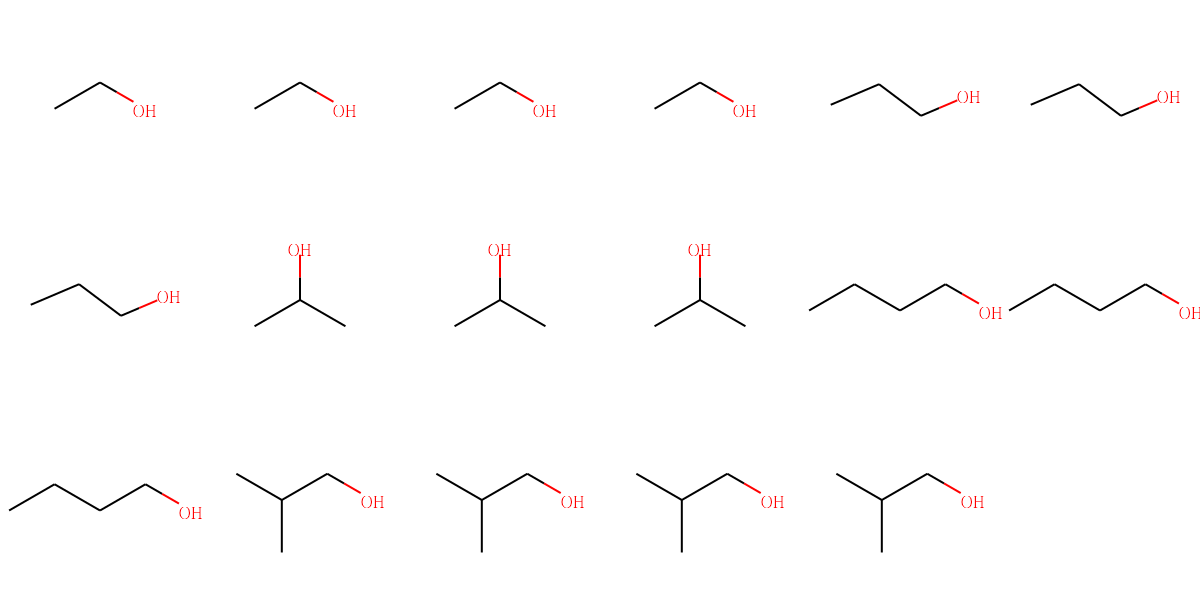

In [61]:
# Show the reactants we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in alcdhy['reactants']], molsPerRow=6, subImgSize=(200, 200))

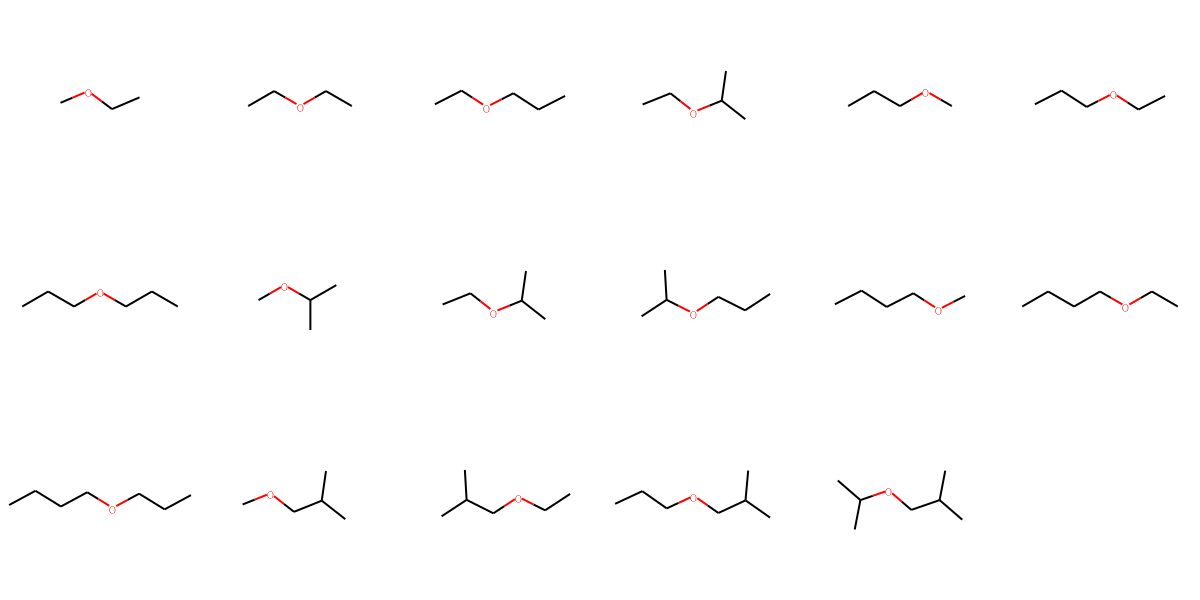

In [62]:
# Show the products we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in alcdhy['products']], molsPerRow=6, subImgSize=(200, 200))

In [63]:
# Transform the molecules above into vector and check the existance in the training set
alcdhy = smi_vec_verify(alcdhy)

Is each reactant contained in the DarkChem training set?: [False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True]
Is each product contained in the DarkChem training set?: [True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False]


In [64]:
# Generate the latent space
alcdhy, alcdhyvec = vec_latent_rxn_vector(alcdhy)

          0         1         2         3         4         5         6   \
0   1.000000  0.576913  0.502995  0.412270  0.345671  0.330784  0.343978   
1   0.576913  1.000000  0.916099  0.672300  0.863099  0.778659  0.765092   
2   0.502995  0.916099  1.000000  0.860326  0.822517  0.933915  0.909939   
3   0.412270  0.672300  0.860326  1.000000  0.574867  0.826805  0.828623   
4   0.345671  0.863099  0.822517  0.574867  1.000000  0.856135  0.790154   
5   0.330784  0.778659  0.933915  0.826805  0.856135  1.000000  0.933646   
6   0.343978  0.765092  0.909939  0.828623  0.790154  0.933646  1.000000   
7   0.358882  0.396801  0.327827  0.115406  0.556524  0.382607  0.500829   
8   0.269018  0.482008  0.680800  0.885835  0.466856  0.695865  0.741895   
9   0.478637  0.659520  0.681790  0.549435  0.598615  0.627557  0.784550   
10  0.276164  0.534664  0.801830  0.825773  0.494940  0.848436  0.813047   
11  0.313349  0.605863  0.789417  0.799214  0.544088  0.779152  0.932597   
12  0.276825

### Then we perform a prediction according to those several alcohol dehydration reactions we loaded:

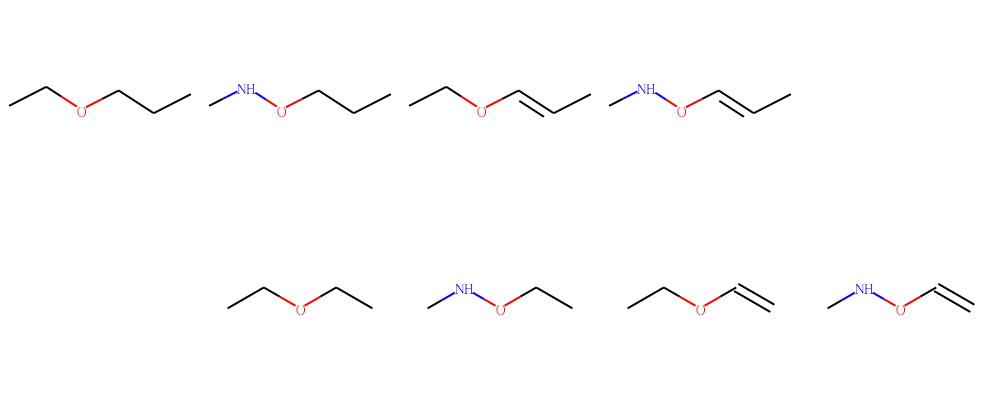

In [77]:
# Predict a certain molecule in the set which just loaded
ethanol = 'CCO'
apply_rxn_vector(ethanol, alcdhyvec, savefilename='Alcohol_Dehydration')

We can see there are 8 outputs for the alcohol underwent the dehydration reaction, those outputs are pretty reasonable and several data will be calculated later.

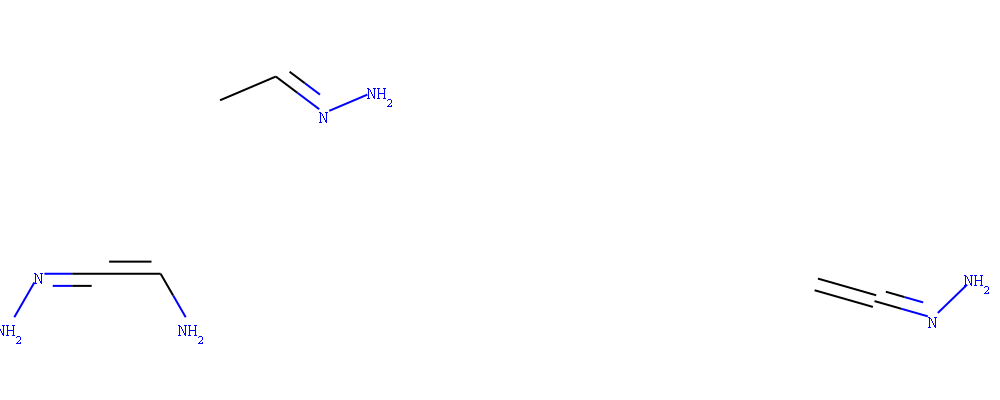

In [78]:
# Predict a new molecule which is not in the set
methanol = 'CO'
apply_rxn_vector(methanol, alcdhyvec, savefilename='Methanol_Dehydration')

But when we predict a molecule that is not in the set which we loaded, the output become so nonsense, the reason why may be that we need to load more reactions.

### Perform the first task: 
* Calculate the average and std dev of angle and magnitude of each vectors of reaction path

In [66]:
# Put those vectors into DataFrame
rct = pd.DataFrame(alcdhy['rlat'])
prod = pd.DataFrame(alcdhy['plat'])

In [67]:
# Calcualte the lengh of each reaction path
d1 = []
for i in range(16):
    s1 = 0
    for j in range(128):
        s1 += (rct.loc[i][j] - prod.loc[i][j])**2
    ds1 = np.sqrt(s1)
    d1.append(ds1)
    
# Calculate the average length of the Alcohol Dehydration reaction path
sum1 = 0
for num in d1:
    sum1 = sum1 + num
    average1 = sum1 / len(d1)

# Calculate the std length of the Alcohol Dehydration reaction path
std1 = statistics.stdev(d1)

In [68]:
# Calculate the dot product of each reaction
d2 = []
for i in range(16):
    s2 = 0
    for j in range(128):
        s2 += (rct.loc[i][j] * prod.loc[i][j])
    #ds = np.sqrt(s)
    d2.append(s2)


# Calculate the product of each reactant and product
d3 = []
for i in range(16):
    s3 = 0
    s4 = 0
    for j in range(128):
        s3 += (rct.loc[i][j])**2
        s4 += (prod.loc[i][j])**2
    dd = np.sqrt(s3)
    dx = np.sqrt(s4)
    xx = dd*dx
    d3.append(xx)

# Insert the formula of Cosine theorem
a1 = []
for i in range(16):
    cos = d2[i]/d3[i]  #this is the value of cos(sita)
    angle = math.acos(cos)  #this is the value of sita
    degree = math.degrees(angle)
    a1.append(degree)

# Calculate the average angle of the Alcohol Dehydration reaction path    
sum2 = 0
for num in a1:
    sum2 = sum2 +num
    average2 = sum2 / len(a1)
    
# Calculate the std angle of the Alcohol Dehydration reaction path
std2 = statistics.stdev(a1)

In [69]:
# Put the length and angle into dataframe
df1 = {'d1':d1,'a1':a1}
df2 = {'average1':average1, 'std1':std1, 'average2':average2, 'std2':std2}
df1 = pd.DataFrame(df1)
df2 = pd.DataFrame(df2, index = [0])
df1.columns = ['Length', 'Angle']
df2.columns = ['Average', 'Std', 'Average', 'Std']
display_html(df1._repr_html_()+df2._repr_html_(), raw=True)

,Length,Angle
0,1.269720,6.557519
1,1.636268,7.447628
2,2.443346,9.868103
3,2.699125,11.410984
4,1.128713,5.446769
5,1.878527,7.536548
6,2.818934,11.546560
7,2.297741,12.198793
8,2.407054,10.139649
9,3.231560,14.327829


The above are the length and angle for each reaction in training sets include their average and std, we can see that the length are between 0.9 and 3.7, the angle are between 6 to 18 degrees.

### Perform the second task:
* Calculate the difference between the predicted vectors and the actual vectors

In [70]:
# Identify the predicted product in the latent space
smistr = 'CCO'
rxnvec = alcdhyvec
nummols = 10

testvec = darkchem.utils.struct2vec(smistr).astype(np.int16)
array_in_nd_array(testvec, x)
    
testlat = model.encoder.predict(np.array(testvec.reshape(-1,100)))
    
testprod = testlat + rxnvec
testpvec = model.decoder.predict(testprod)
testprods = darkchem.utils.beamsearch(testpvec, k=nummols)
    
predictions = {}
    
predictions['predprod'] = [darkchem.utils.vec2struct(i) for i in testprods[0]]

In [71]:
# Locate the predicted product in the latent space
reactant = {'reactants':['CCO','CCO','CCO','CCO','CCO','CCO','CCO','CCO','CCO','CCO']}
actualprod = {'products':['CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC','CCOCC']}

reactantvect = {}
actualprodvect = {}
predictionsvect = {}

reactantvect['reactant'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in reactant['reactants']]
actualprodvect['actualprod'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in actualprod['products']]
predictionsvect['predprod'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in predictions['predprod']]

reactantvect['reactantlat'] = model.encoder.predict(np.array(reactantvect['reactant']))
actualprodvect['actualprodlat'] = model.encoder.predict(np.array(actualprodvect['actualprod']))
predictionsvect['predprodlat'] = model.encoder.predict(np.array(predictionsvect['predprod']))

In [72]:
# Put those vectors into DataFrame
rct = pd.DataFrame(reactantvect['reactantlat'])
aprod = pd.DataFrame(actualprodvect['actualprodlat'])
pprod = pd.DataFrame(predictionsvect['predprodlat'])

In [73]:
# Calcualte the lengh between each predicted product and actual product
d4 = []
for i in range(10):
    s5 = 0
    for j in range(128):
        s5 += (pprod.loc[i][j] - aprod.loc[i][j])**2
    ds2 = np.sqrt(s5)
    d4.append(ds2)
    
# Calculate the average lengh between each predicted product and actual product
sum3 = 0
for num in d4:
    sum3 = sum3 +num
    average3 = sum3 / len(d4)

# Calculate the std of length between each predicted product and actual product
std3 = statistics.stdev(d4)

In [74]:
# Calcualte the lengh of the vector for each predicted product
d5 = []
for i in range(10):
    s6 = 0
    for j in range(128):
        s6 += (pprod.loc[i][j] - rct.loc[i][j])**2
    ds3 = np.sqrt(s6)
    d5.append(ds3)
    
# Calculate the average lengh of the vector for each predicted product
sum4 = 0
for num in d5:
    sum4 = sum4 +num
    average4 = sum4 / len(d5)

# Calculate the std of length of the vector for each predicted product
std4 = statistics.stdev(d5)

In [75]:
# Calculate the dot product of each reaction
d6= []
for i in range(10):
    s7 = 0
    for j in range(128):
        s7 += (rct.loc[i][j] * pprod.loc[i][j])
    #ds = np.sqrt(s)
    d6.append(s7)


# Calculate the product of each reactant and product
d7= []
for i in range(10):
    s8 = 0
    s9 = 0
    for j in range(128):
        s8 += (rct.loc[i][j])**2
        s9 += (pprod.loc[i][j])**2
    dd = np.sqrt(s8)
    dx = np.sqrt(s9)
    xx = dd*dx
    d7.append(xx)

# Insert the formula of Cosine theorem
a2 = []
for i in range(10):
    cos = d2[i]/d3[i]  #this is the value of cos(sita)
    angle = math.acos(cos)  #this is the value of sita
    degree = math.degrees(angle)
    a2.append(degree)

# Calculate the average angle of each predicted Alcohol Dehydration reaction path    
sum5 = 0
for num in a2:
    sum5 = sum5 +num
    average5 = sum5 / len(a2)
    
# Calculate the std angle of each predicted Alcohol Dehydration reaction path
std5 = statistics.stdev(a2)

In [76]:
# Put the length and angle into dataframe
df3 = {'d4':d4, 'd5':d5, 'a2':a2}
df4 = {'average3':average3, 'std3':std3, 'average4':average4, 'std4':std4, 'average5':average5, 'std5':std5}
df3 = pd.DataFrame(df3)
df4 = pd.DataFrame(df4, index = [0])
df3.columns = ['Distance between each predicted product and actual product', 'Length of each predicted reaction vector', 'Angle of each predicted reaction vector']
df4.columns = ['Average', 'Std', 'Average', 'Std', 'Average', 'Std']
display_html(df3._repr_html_()+df4._repr_html_(), raw=True)

,Distance between each predicted product and actual product,Length of each predicted reaction vector,Angle of each predicted reaction vector
0,1.149738,2.443346,6.557519
1,1.081474,2.230340,7.447628
2,1.373985,2.477477,9.868103
3,1.410727,2.410955,11.410984
4,1.232006,1.811045,5.446769
5,1.347436,1.800887,7.536548
6,0.000000,1.636268,11.546560
7,0.498640,1.598143,12.198793
8,0.900040,1.655188,10.139649
9,1.074499,1.615253,14.327829


This table shows that:

* The distance between each predicted product and actual product	
* The length of each predicted reaction vector
* The angle of each predicted reaction vector

From the distance between each predicted product and actual product, we can find that the 7th ( showed up as the 4 th product in beamsearch) predicted product is the correct product we want, but on the other hand, the rest of the product are also in the "ether" group, so they are also possible to be the product for an alcohol to undergo the dehydration reaction, so we think the prediction are pretty accurate so far.

#### The differences bewteen the actual and the predicted reaction vectors:
| Index         |   Length|    Angle| 
|---------------|---------|---------|
|         Actual| 1.269720| 6.557519|
| Predicted(Avg)| 1.967890| 9.648038|
| Predicted(Std)| 0.375978| 2.826687|

From the table above, we can see that the length and angle of actual reaction (alcohol to ether) is 1.26972 and 6.557519 degree respectively, and average length and angle calculated from those 10 predicted reactions is 1.96789 and 9.648038 degree.

In this point, to add more reactions to training set may be a way to increase the accuracy of the prediction.

### Perform the third task:
* Perform a deeper analysis of the molecules generated within 1 std dev of the average vector